In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_func = np.linspace(-4,4,100)
y_func = x_func

x_train = np.random.uniform(-3, -2, 50)
y_train = x_train + np.random.randn(*x_train.shape)*0.5

x_train = np.concatenate([x_train, np.random.uniform(2, 3, 50)])
y_train = np.concatenate([y_train, x_train[50:] + np.random.randn(*x_train[50:].shape)*0.1])
x_test = np.linspace(-10,10,100)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, label='training data')
ax.plot(x_func, y_func, ls='--', label='real function', color='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Data with uncertainty')
plt.show()



<Figure size 1000x500 with 1 Axes>

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


In [3]:
class Model(nn.Module):
    def __init__(self, layer_dims, dropout_prob=0):
        super().__init__()

        self.linears = []
        self.dropout = nn.Dropout(dropout_prob)
        for i, layer_dim in enumerate(layer_dims[:-1]):
            layer = nn.Linear(layer_dim, layer_dims[i+1])
            setattr(self, f"layer_{str(i)}", layer)
            self.linears.append(layer)
            # self.layers.append(nn.Linear(layer_dim, layer_dims[i+1]))

    def forward(self, x):
        for layer in self.linears[:-1]:
            x = F.elu(self.dropout(layer(x)))
        x = self.linears[-1](x)
        return x



In [4]:
x_tr = torch.Tensor(x_train).reshape(-1, 1)
y_tr = torch.Tensor(y_train).reshape(-1, 1)


loader = DataLoader(TensorDataset(x_tr, y_tr), batch_size=10, shuffle=True)


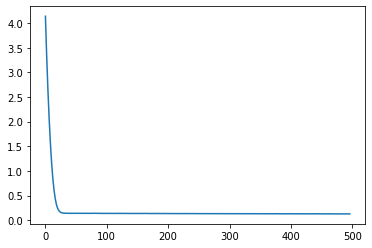

In [5]:
# dims = [1, 5, 10, 20, 10, 5, 1]
dims = [1, 16, 32, 32, 1]

def train(model):
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-3)
    epochs = 500

    losses = []
    for e in range(epochs):
        epoch_losses = []
        for x_batch, y_batch in loader:
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(y_batch, predictions)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        losses.append(np.mean(epoch_losses))
    plt.plot(losses[3:])
model_1 = Model(dims, 0)
train(model_1)

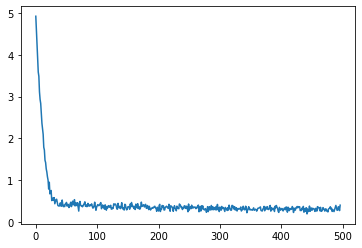

In [6]:
model_2 = Model(dims, 0.2)
train(model_2)


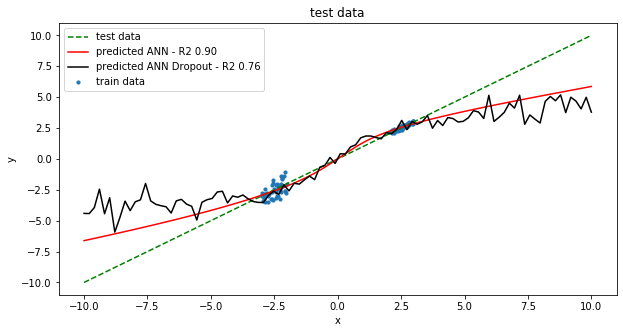

In [7]:
from sklearn.metrics import r2_score


x_tst = torch.Tensor(x_test).reshape(-1, 1)
# prediction
with torch.no_grad():
    y_pred_without_dropout = model_1(x_tst)
    y_pred_with_dropout = model_2(x_tst)

# plotting
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, s=10, label='train data')
ax.plot(x_test, x_test, ls='--', label='test data', color='green')
ax.plot(x_test, y_pred_without_dropout, label='predicted ANN - R2 {:.2f}'.format(r2_score(x_test, y_pred_without_dropout)), color='red')
ax.plot(x_test, y_pred_with_dropout, label='predicted ANN Dropout - R2 {:.2f}'.format(r2_score(x_test, y_pred_with_dropout)), color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('test data');


/home/mephody_bro/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]
/home/mephody_bro/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


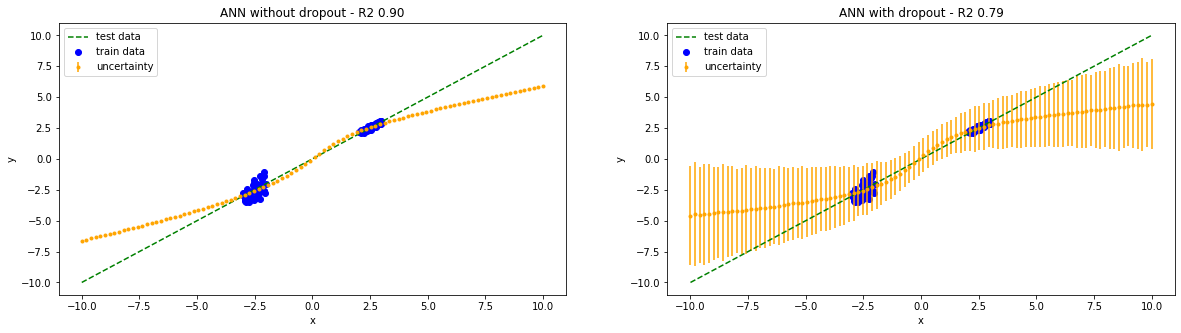

In [8]:
def plot_epistemic_uncertainty(model, ax, title,
                     x_test=np.linspace(-10,10,100), y_test=np.linspace(-10,10,100),
                     T=500):
    predictions = []
    x_tst = torch.Tensor(x_test).reshape(-1, 1)
    with torch.no_grad():
        for _ in range(T):
            predictions += [model(x_tst).numpy()]

    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    ax.plot(x_test, y_test, ls='--', color='green', label='test data')
    ax.scatter(x_train, y_train, color='blue', label='train data')
    ax.errorbar(x_test, mean, yerr=5*std, fmt='.', color='orange', label='uncertainty')
    ax.set_title('{} - R2 {:.2f}'.format(title, r2_score(y_test, mean)))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend();

fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_epistemic_uncertainty(model_1, ax=ax[0], title='ANN without dropout')
plot_epistemic_uncertainty(model_2, ax=ax[1], title='ANN with dropout')